### Import Necessary Libraries 

In [ ]:
# Core libraries
import os
import numpy as np
import pandas as pd
import textwrap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & modeling
from scipy.stats import mannwhitneyu, ttest_ind
from scipy.stats.mstats import winsorize
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import LogisticRegression

# Tables & summaries
from tableone import TableOne
from tabulate import tabulate


In [ ]:
# read data from excel file
Main = pd.read_excel("Merged_Data.xlsx")


In [ ]:
# column names
Main.columns

Index(['National_Drug_ID', 'ReferenceNumber', 'Old_register_Number',
       'Registration_Year', 'DrugType', 'Sub-Type', 'Scientific_Name',
       'Trade_Name', 'Strength', 'StrengthUnit', 'PharmaceuticalForm',
       'AdministrationRoute', 'PackageTypes', 'PackageSize', 'Legal_Status',
       'Product_Control', 'Distribute_area', 'Public_price',
       'Marketing_Company', 'Marketing_Country', 'Regulatory_Approval',
       'Manufacture_Name', 'Manufacture_Country',
       'Secondry_package__manufacture', 'Main_Agent', 'Secosnd_Agent',
       'Third_agent', 'Description_Code', 'Authorization_Status',
       'International_Drug_ID', 'Brand_Name', 'Company_(Parent)',
       'POL_Dosage_Form', 'Strength_Comment', 'Company_(Subsidiary)',
       'Drug_Type', 'POL_Hospital_Status', 'POL_Parallel_Import',
       'EMA_Brand_ID', 'ATC_Code', 'POL_First_Price_Date',
       'POL_First_Price_(LCU)', 'POL_First_Price_%_Change',
       'POL_Ex-manufacturer_Price_(USD)', 'POL_Wholesale_Price_(USD)',


---

# Create Necessary Columns

## Identify intervention groups



In [ ]:
# Create a copy of Main that only includes rows with non-missing Invention_Year
Main_non_missing_invention_year = Main.dropna(subset=["Invention_Year"]).copy()

# Calculate the median of the Price_Per_Unit_(LCU) column
median_price_per_unit = Main_non_missing_invention_year["Price_Per_Unit_(LCU)"].median()

# Create the Intervention_Group column based on the median price
Main_non_missing_invention_year["Intervention_Group"] = Main_non_missing_invention_year[
    "Price_Per_Unit_(LCU)"
].apply(lambda x: "Expensive" if x > median_price_per_unit else "Cheap")

In [ ]:
# what's the median price per unit?
median_price_per_unit


142.20499999999998

In [ ]:
# print how many Cheap and Expensive drugs are there
print(Main_non_missing_invention_year["Intervention_Group"].value_counts())

Intervention_Group
Cheap        535
Expensive    535
Name: count, dtype: int64


## Generate `lagging_time`

In [ ]:
# Generate lagging_time variable
Main_non_missing_invention_year["lagging_time"] = (
    Main_non_missing_invention_year["Registration_Year"]
    - Main_non_missing_invention_year["Invention_Year"]
)

# Display the first few rows to verify
print(
    Main_non_missing_invention_year[
        ["Registration_Year", "Invention_Year", "lagging_time"]
    ].head()
)

   Registration_Year  Invention_Year  lagging_time
0               2019          2017.0           2.0
1               2018          2012.0           6.0
2               2019          2017.0           2.0
3               2019          2017.0           2.0
4               2019          2018.0           1.0


---

# Examine Distributions

Number of rows in the pre and post periods that have **NON MISSING** `Lagging_Time`



In [ ]:
# Assuming 'Main_non_missing' is your DataFrame without missing values

# Filter data for pre-2021 and post-2021
pre_2021 = Main_non_missing_invention_year[
    Main_non_missing_invention_year["Registration_Year"] < 2021
]
post_2021 = Main_non_missing_invention_year[
    Main_non_missing_invention_year["Registration_Year"] >= 2021
]

# Count the number of entries in each intervention group for pre-2021
pre_2021_counts = pre_2021["Intervention_Group"].value_counts()

# Count the number of entries in each intervention group for post-2021
post_2021_counts = post_2021["Intervention_Group"].value_counts()

# Create a DataFrame to display the counts in a table format
intervention_counts = (
    pd.DataFrame({"Pre-2021": pre_2021_counts, "Post-2021": post_2021_counts})
    .fillna(0)
    .astype(int)
)

# Add a 'Total' column for each row
intervention_counts["Total"] = (
    intervention_counts["Pre-2021"] + intervention_counts["Post-2021"]
)

# Add a 'Total' row for each column
intervention_counts.loc["Total"] = intervention_counts.sum(numeric_only=True, axis=0)

# Display the table
print(intervention_counts)

                    Pre-2021  Post-2021  Total
Intervention_Group                            
Cheap                    339        196    535
Expensive                191        344    535
Total                    530        540   1070


In [ ]:
# Group by Registration_Year and Intervention_Group and count the occurrences
registration_year_counts = (
    Main_non_missing_invention_year.groupby(["Registration_Year", "Intervention_Group"])
    .size()
    .unstack(fill_value=0)
)

# Display the counts
print(registration_year_counts)

Intervention_Group  Cheap  Expensive
Registration_Year                   
2016                  102         33
2017                   59         62
2018                   70         22
2019                   52         17
2020                   56         57
2021                   40         97
2022                   48         74
2023                   76         80
2024                   32         93


In [ ]:
num_therapeutic_categories = Main_non_missing_invention_year[
    "Therapeutic_Use"
].nunique()
print("Number of therapeutic categories:", num_therapeutic_categories)

Number of therapeutic categories: 15


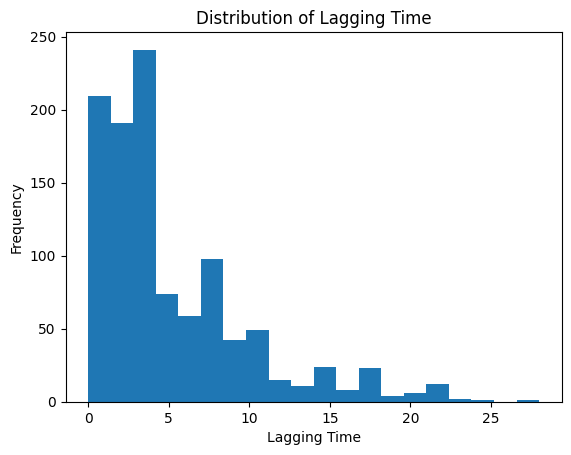

In [ ]:
# show the distribution of lagging time on a histogram
plt.hist(Main_non_missing_invention_year["lagging_time"], bins=20)
plt.xlabel("Lagging Time")
plt.ylabel("Frequency")
plt.title("Distribution of Lagging Time")
plt.show()


#### Mean Lagging over Time

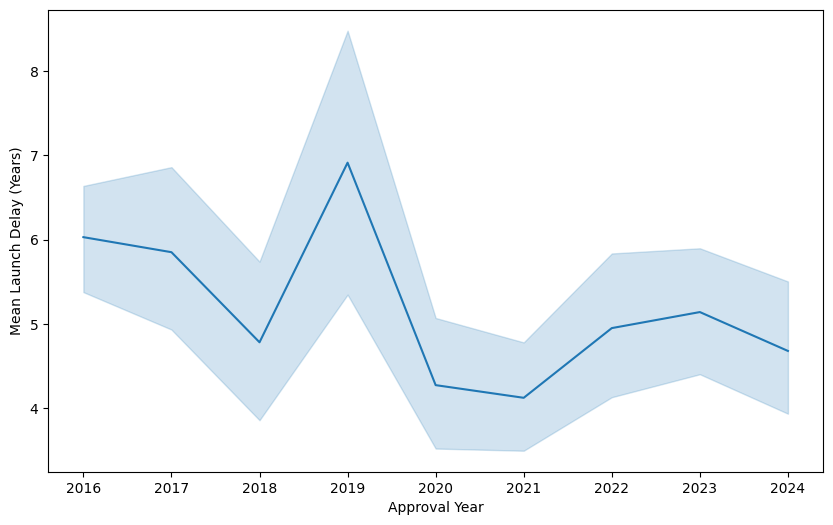

In [ ]:
# plot the trend of lagging time over years
plt.figure(figsize=(10, 6))
sns.lineplot(
    x="Registration_Year", y="lagging_time", data=Main_non_missing_invention_year
)
plt.ylabel("Mean Launch Delay (Years)")
plt.xlabel("Approval Year")
plt.show()

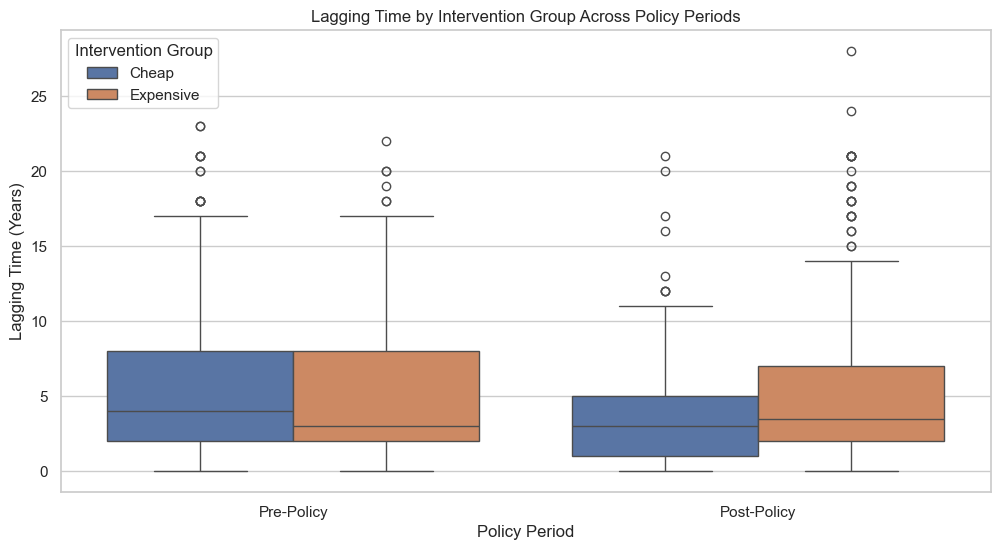

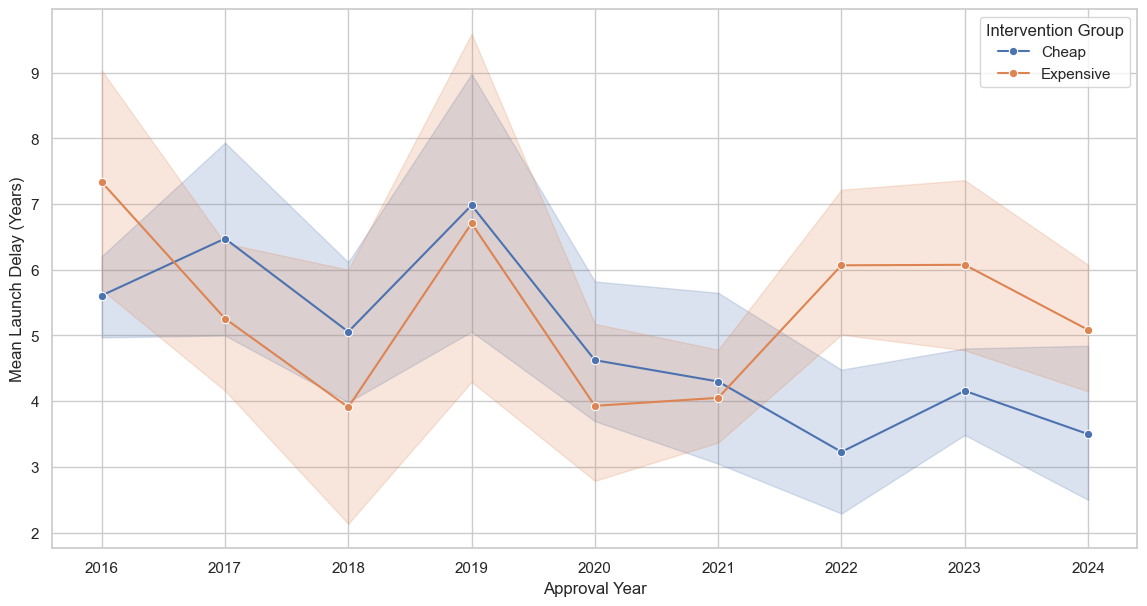

In [ ]:
# Filter the data for rows with non-null lagging time
Main_filtered = Main_non_missing_invention_year.dropna(
    subset=["lagging_time", "Registration_Year", "Intervention_Group"]
)

# Create a new column to indicate policy period (pre-policy and post-policy)
Main_filtered["policy_period"] = Main_filtered["Registration_Year"].apply(
    lambda x: "Pre-Policy" if x < 2021 else "Post-Policy"
)

# Set the plotting style
sns.set(style="whitegrid")

# Create a boxplot for lagging time across different intervention groups and policy periods
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="policy_period", y="lagging_time", hue="Intervention_Group", data=Main_filtered
)
plt.title("Lagging Time by Intervention Group Across Policy Periods")
plt.xlabel("Policy Period")
plt.ylabel("Lagging Time (Years)")
plt.legend(title="Intervention Group")
plt.show()

# Create a line plot to observe the trend over years for each intervention group
plt.figure(figsize=(14, 7))
sns.lineplot(
    x="Registration_Year",
    y="lagging_time",
    hue="Intervention_Group",
    data=Main_filtered,
    marker="o",
)
plt.xlabel("Approval Year")
plt.ylabel("Mean Launch Delay (Years)")
plt.legend(title="Intervention Group")
plt.show()


---

# Analysis

# Descriptive Charachteristics of Drugs by Intervention Group and Policy Period

In [ ]:
# ---- STEP 1: Rename ATC categories ---- #
atc_rename_map = {
    "Various": "Various",
    "Systemic hormonal preparations (excluding sex hormones & insulins)": "Systemic Hormonal (excl. sex hormones & insulin)",
    "Sensory organs": "Sensory Organs",
    "Respiratory system": "Respiratory System",
    "Nervous system": "Nervous System",
    "Musculoskeletal system": "Musculoskeletal System",
    "Genito-urinary system & sex hormones": "Genito-urinary System & Sex Hormones",
    "Dermatologicals": "Dermatological",
    "Cardiovascular system": "Cardiovascular System",
    "Blood & blood-forming organs": "Blood & Blood-forming Organs",
    "Antineoplastic & immunomodulating agents": "Antineoplastic & Immunomodulating Agents",
    "Anti-infectives for systemic use": "Anti-infectives for Systemic Use",
}

Main_non_missing_invention_year["ATC_Main_Category"] = Main_non_missing_invention_year[
    "ATC_Main_Category"
].replace(atc_rename_map)

# ---- STEP 2: Create TableOne without "Missing" column ---- #
columns = [
    "lagging_time",
    "DrugType",
    "Distribute_area",
    "ATC_Main_Category",
    "Regulatory_Region",
    "Essential_Med",
]
categorical = [
    "DrugType",
    "Distribute_area",
    "ATC_Main_Category",
    "Regulatory_Region",
    "Essential_Med",
]
groupby = "Intervention_Group"

table1 = TableOne(
    data=Main_non_missing_invention_year,
    columns=columns,
    categorical=categorical,
    groupby=groupby,
    pval=True,
    missing=False,  # <<< hides the 'Missing' column
)

# ---- STEP 3: Custom stats for lagging_time ---- #
lag_stats = (
    Main_non_missing_invention_year.groupby("Intervention_Group")["lagging_time"]
    .agg(Mean="mean", SD="std", Median="median", Min="min", Max="max")
    .round(2)
    .reset_index()
)

# Create formatted rows
mean_sd = lag_stats.copy()
mean_sd["Variable"] = "lagging_time, mean (SD)"
mean_sd["Value"] = mean_sd.apply(lambda row: f"{row['Mean']} ({row['SD']})", axis=1)

median_range = lag_stats.copy()
median_range["Variable"] = "lagging_time, median [min, max]"
median_range["Value"] = median_range.apply(
    lambda row: f"{row['Median']} [{row['Min']}, {row['Max']}]", axis=1
)

# Combine both custom rows
lagging_time_stats = pd.concat(
    [
        mean_sd[["Intervention_Group", "Variable", "Value"]],
        median_range[["Intervention_Group", "Variable", "Value"]],
    ]
)

# Pivot so it matches the format of tableone output
lagging_time_stats = lagging_time_stats.pivot(
    index="Variable", columns="Intervention_Group", values="Value"
).reset_index()

# Add empty Overall and P-Value columns to match TableOne format
lagging_time_stats.insert(1, "Overall", "")
lagging_time_stats["P-Value"] = ""

# ---- STEP 4: Export both to Excel ---- #
with pd.ExcelWriter("Results/Baseline_both periods.xlsx", engine="openpyxl") as writer:
    # Write TableOne without 'Missing' column
    table1.tableone.to_excel(writer, sheet_name="TableOne_Cleaned")

    # Append custom lagging time summary
    lagging_time_stats.to_excel(writer, sheet_name="LaggingTime_Detailed", index=False)

# Main DiD Analysis

# 1- Parallel Trends Check (Pre-policy Only)


In [ ]:
# Filter data to pre-policy years only
pre_data = Main_non_missing_invention_year[
    Main_non_missing_invention_year["Registration_Year"] < 2021
].copy()

# Center year around 2020 to reduce scale and multicollinearity
pre_data["year_trend"] = (
    pre_data["Registration_Year"] - 2020
)  # 2020 will be the reference year

# Run the pre-trend regression with interaction
model_pretrend = smf.ols(
    "lagging_time ~ year_trend + Intervention_Group + year_trend:Intervention_Group",
    data=pre_data,
).fit()

# Display the results
print(model_pretrend.summary())

                            OLS Regression Results                            
Dep. Variable:           lagging_time   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.729
Date:                Sat, 19 Apr 2025   Prob (F-statistic):             0.0434
Time:                        16:44:00   Log-Likelihood:                -1594.3
No. Observations:                 530   AIC:                             3197.
Df Residuals:                     526   BIC:                             3214.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

✔️ This model supports the parallel trends assumption. The interaction is NOT significant (p = 0.210), which suggests that lagging time trends were similar between cheap and expensive drugs before the real policy.





# 2- Main DiD Model

In [ ]:
# Create a new column to indicate the policy period (pre-policy and post-policy)
Main_non_missing_invention_year["post_policy"] = Main_non_missing_invention_year[
    "Registration_Year"
].apply(lambda x: 1 if x >= 2021 else 0)

# Define the Difference-in-Differences model
# 'Intervention2' identifies the intervention (Expensive) and control (Cheap) groups
# 'post_policy' indicates whether the observation is before or after the policy change
# 'lagging_time' is the outcome variable
model = smf.ols(
    "lagging_time ~ Intervention_Group * post_policy",
    data=Main_non_missing_invention_year,
).fit()

# Display the summary of the model to check for the interaction term significance
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           lagging_time   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     6.464
Date:                Sat, 10 May 2025   Prob (F-statistic):           0.000245
Time:                        14:11:30   Log-Likelihood:                -3176.8
No. Observations:                1070   AIC:                             6362.
Df Residuals:                    1066   BIC:                             6381.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [ ]:
# print names of ATC categories
atc_categories = Main_non_missing_invention_year["ATC_Main_Category"].unique()
print(atc_categories)

['Alimentary tract & metabolism' 'Anti-infectives for systemic use'
 'Various' 'Antineoplastic & immunomodulating agents'
 'Genito-urinary system & sex hormones' 'Nervous system'
 'Blood & blood-forming organs' 'Dermatologicals' 'Sensory organs'
 'Respiratory system'
 'Systemic hormonal preparations (excluding sex hormones & insulins)'
 'Cardiovascular system' 'Musculoskeletal system']


# 3-Model with Year-Fixed Effects



In [ ]:
Main_non_missing_invention_year["post_policy"] = Main_non_missing_invention_year[
    "Registration_Year"
].apply(lambda x: 1 if x >= 2021 else 0)

# Convert 'Intervention_Group' to numeric values
Main_non_missing_invention_year["Intervention_Group"] = Main_non_missing_invention_year[
    "Intervention_Group"
].map({"Cheap": 0, "Expensive": 1})

# Check if conversion worked
print(
    Main_non_missing_invention_year["Intervention_Group"].unique()
)  # Should show [0,1] if successfu


[0 1]


In [ ]:
year_model = smf.ols(
    "lagging_time ~ C(Registration_Year) + Intervention_Group + Intervention_Group:post_policy",
    data=Main_non_missing_invention_year,
).fit()
print(year_model.summary())

                            OLS Regression Results                            
Dep. Variable:           lagging_time   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     4.373
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           4.96e-06
Time:                        16:44:12   Log-Likelihood:                -3164.8
No. Observations:                1070   AIC:                             6352.
Df Residuals:                    1059   BIC:                             6406.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# 3- Full Model with Controls  


In [ ]:
Full_model = smf.ols(
    "lagging_time ~ C(Registration_Year) + Intervention_Group + Intervention_Group:post_policy + ATC_Main_Category + Regulatory_Region + Distribute_area + Essential_Med",
    data=Main_non_missing_invention_year,
).fit()

print(Full_model.summary())

                            OLS Regression Results                            
Dep. Variable:           lagging_time   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.631
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.31e-09
Time:                        16:44:16   Log-Likelihood:                -3140.1
No. Observations:                1070   AIC:                             6334.
Df Residuals:                    1043   BIC:                             6468.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

# All DiD models in one table

In [ ]:
# Fit your 3 models (as you've done already)
model1 = smf.ols(
    "lagging_time ~ Intervention_Group * post_policy",
    data=Main_non_missing_invention_year,
).fit()

model2 = smf.ols(
    "lagging_time ~ C(Registration_Year) + Intervention_Group + Intervention_Group:post_policy",
    data=Main_non_missing_invention_year,
).fit()

model3 = smf.ols(
    "lagging_time ~ C(Registration_Year) + Intervention_Group + Intervention_Group:post_policy + \
                  ATC_Main_Category + Regulatory_Region + Distribute_area + Essential_Med",
    data=Main_non_missing_invention_year,
).fit()

# Create a nice formatted table
results_table = summary_col(
    results=[model1, model2, model3],
    float_format="%0.2f",
    stars=True,
    model_names=["(1) Basic DiD", "(2) + Year FE", "(3) + Full Controls"],
    info_dict={
        "N": lambda x: f"{int(x.nobs)}",
        "R-squared": lambda x: f"{x.rsquared:.2f}",
    },
    regressor_order=[
        "Intercept",
        "Intervention_Group[T.Expensive]",
        "post_policy",
        "Intervention_Group[T.Expensive]:post_policy",
    ],
)

# Print in terminal
print(results_table)

# Save the HTML version in the Results folder
with open("Results/DiD_Regression_Table.html", "w") as f:
    f.write(results_table.as_html())


                                                                      (1) Basic DiD (2) + Year FE (3) + Full Controls
---------------------------------------------------------------------------------------------------------------------
Intercept                                                             5.69***       6.11***       6.36***            
                                                                      (0.26)        (0.42)        (0.70)             
post_policy                                                           -1.84***                                       
                                                                      (0.42)                                         
Intervention_Group                                                    -0.50         -0.32         0.00               
                                                                      (0.43)        (0.44)        (0.49)             
Essential_Med[T.yes]                                   

### Now formating the main table and renaming the variables

In [ ]:
# Fit models
model1 = smf.ols(
    "lagging_time ~ Intervention_Group * post_policy",
    data=Main_non_missing_invention_year,
).fit()
model2 = smf.ols(
    "lagging_time ~ C(Registration_Year) + Intervention_Group + Intervention_Group:post_policy",
    data=Main_non_missing_invention_year,
).fit()
model3 = smf.ols(
    "lagging_time ~ C(Registration_Year) + Intervention_Group + Intervention_Group:post_policy + ATC_Main_Category + Regulatory_Region + Distribute_area + Essential_Med",
    data=Main_non_missing_invention_year,
).fit()

# Create base summary_col
results = summary_col(
    [model1, model2, model3],
    stars=True,
    float_format="%.2f",
    model_names=["Model 1", "Model 2", "Model 3"],
    info_dict={
        "N": lambda x: f"{int(x.nobs)}",
        "R-squared": lambda x: f"{x.rsquared:.2f}",
    },
)

# Extract the table as DataFrame
results_table = results.tables[0]

# Separate coefficients and SEs
rows = []
for i in range(0, len(results_table), 2):  # Coef rows
    coef_row = results_table.iloc[i]
    se_row = results_table.iloc[i + 1]
    combined = []
    for coef, se in zip(coef_row, se_row):
        coef_clean = coef
        se_clean = se.strip("()")
        combined.extend([coef_clean, se_clean])
    rows.append(combined)

# Column headers (Coef + SE side-by-side)
columns = []
for name in results_table.columns:
    columns.extend([f"{name} Coef", f"{name} SE"])

# Build DataFrame
formatted_df = pd.DataFrame(rows, columns=columns)
formatted_df.insert(0, "Variable", results_table.index[::2])

# Save to Excel and HTML
os.makedirs("Results", exist_ok=True)
formatted_df.to_excel("Results/DiD_Regression_Table_SideBySide.xlsx", index=False)
formatted_df.to_html("Results/DiD_Regression_Table_SideBySide.html", index=False)

# Optional preview
print(formatted_df.head())

                         Variable Model 1 Coef Model 1 SE Model 2 Coef  \
0                       Intercept      5.69***       0.26      6.11***   
1              Intervention_Group        -0.50       0.43        -0.32   
2                     post_policy     -1.84***       0.42                
3  Intervention_Group:post_policy      1.88***       0.60      1.88***   
4    C(Registration_Year)[T.2017]                                -0.09   

  Model 2 SE Model 3 Coef Model 3 SE  
0       0.42      6.36***       0.70  
1       0.44         0.00       0.49  
2                                     
3       0.61      1.80***       0.61  
4       0.60        -0.38       0.61  


In [ ]:
# Dictionary to rename ATC categories
atc_rename = {
    "ATC_Main_Category[T.Various]": "Various",
    "ATC_Main_Category[T.Systemic hormonal preparations (excluding sex hormones & insulins)]": "Systemic Hormonal (excl. sex hormones & insulin)",
    "ATC_Main_Category[T.Sensory organs]": "Sensory Organs",
    "ATC_Main_Category[T.Respiratory system]": "Respiratory System",
    "ATC_Main_Category[T.Nervous system]": "Nervous System",
    "ATC_Main_Category[T.Musculoskeletal system]": "Musculoskeletal System",
    "ATC_Main_Category[T.Genito-urinary system & sex hormones]": "Genito-urinary System & Sex Hormones",
    "ATC_Main_Category[T.Dermatologicals]": "Dermatological",
    "ATC_Main_Category[T.Cardiovascular system]": "Cardiovascular System",
    "ATC_Main_Category[T.Blood & blood-forming organs]": "Blood & Blood-forming Organs",
    "ATC_Main_Category[T.Antineoplastic & immunomodulating agents]": "Antineoplastic & Immunomodulating Agents",
    "ATC_Main_Category[T.Anti-infectives for systemic use]": "Anti-infectives for Systemic Use",
}
# Dictionary to rename year dummies
year_rename = {
    "C(Registration_Year)[T.2017]": "Year 2017",
    "C(Registration_Year)[T.2018]": "Year 2018",
    "C(Registration_Year)[T.2019]": "Year 2019",
    "C(Registration_Year)[T.2020]": "Year 2020",
    "C(Registration_Year)[T.2021]": "Year 2021",
    "C(Registration_Year)[T.2022]": "Year 2022",
    "C(Registration_Year)[T.2023]": "Year 2023",
    "C(Registration_Year)[T.2024]": "Year 2024",
}

# Apply both ATC and year renaming
formatted_df["Variable"] = (
    formatted_df["Variable"].replace(atc_rename).replace(year_rename)
)

formatted_df.to_excel("Results/DiD_Regression_Table_SideBySide.xlsx", index=False)
formatted_df.to_html("Results/DiD_Regression_Table_SideBySide.html", index=False)

# Separate Full Tables for Appendix (with CIs, p-values, SEs)

In [ ]:
# Export each model’s full summary (with CI, SE, t, p) to text
model_list = [("Basic_DiD", model1), ("Year_FE", model2), ("Full_Controls", model3)]

for name, model in model_list:
    summary_txt = model.summary().as_text()

    with open(f"{name}_Full_Model.txt", "w") as f:
        f.write(summary_txt)

    print(f"\n=== {name} ===")
    print(summary_txt)

for name, model in model_list:
    with open(f"{name}_Full_Model.html", "w") as f:
        f.write(model.summary().as_html())


=== Basic_DiD ===
                            OLS Regression Results                            
Dep. Variable:           lagging_time   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     6.464
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           0.000245
Time:                        13:39:02   Log-Likelihood:                -3176.8
No. Observations:                1070   AIC:                             6362.
Df Residuals:                    1066   BIC:                             6381.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

---

# Visualizations

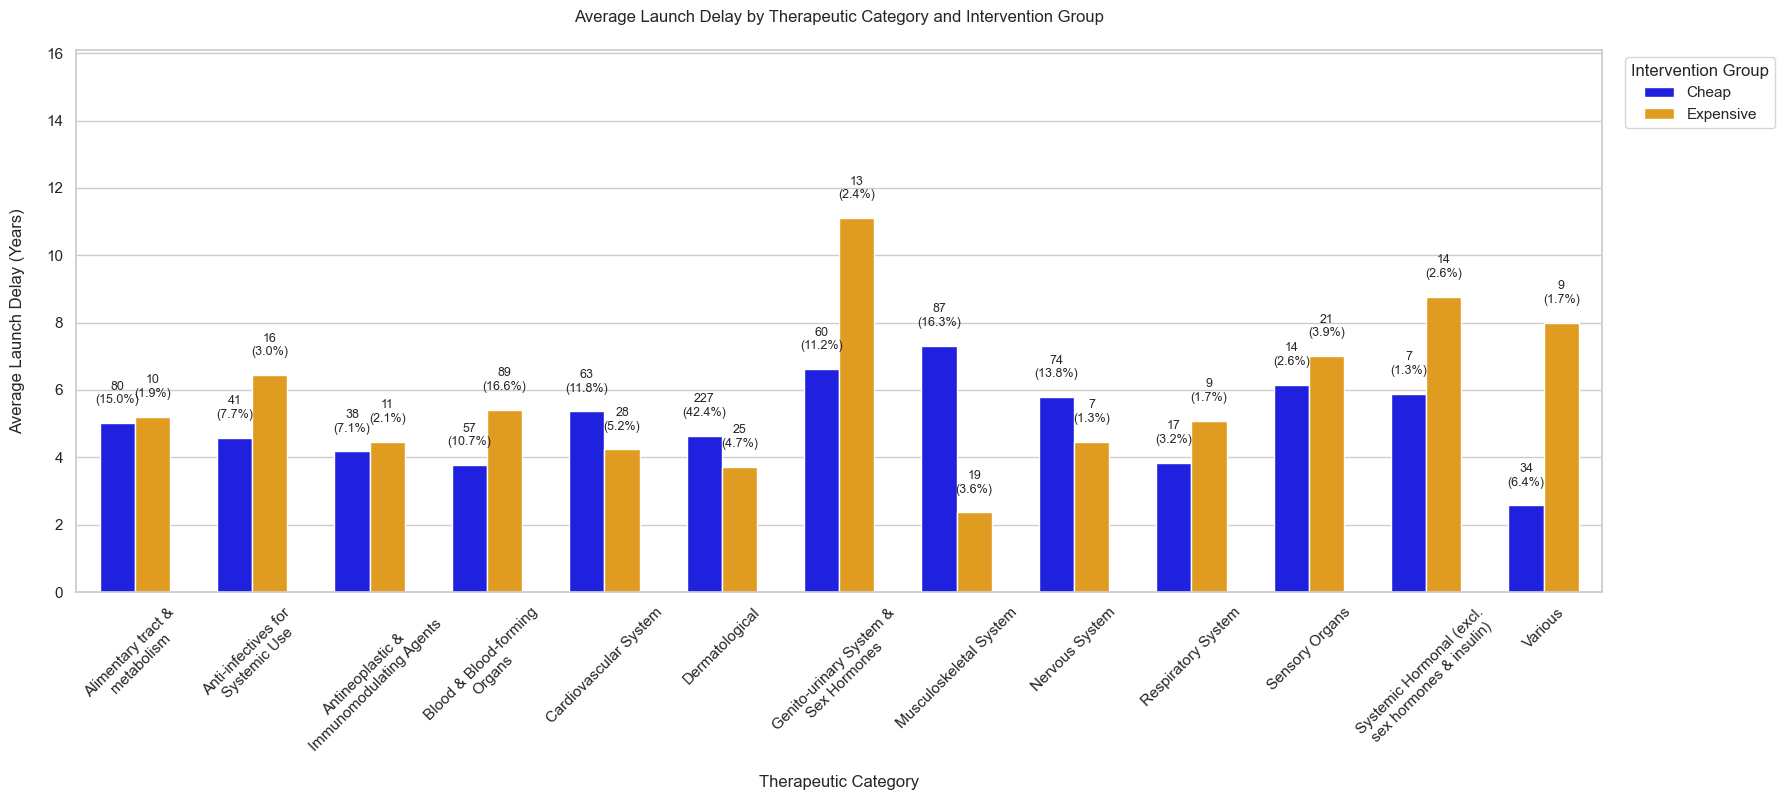

In [ ]:
# Clean & map
Main_filtered = Main_non_missing_invention_year.dropna(
    subset=[
        "lagging_time",
        "Registration_Year",
        "Intervention_Group",
        "ATC_Main_Category",
    ]
).copy()
Main_filtered["Intervention_Group"] = Main_filtered["Intervention_Group"].map(
    {0: "Cheap", 1: "Expensive"}
)

# Totals for % calculation
group_totals = Main_filtered["Intervention_Group"].value_counts().to_dict()

# Summarize
summary = (
    Main_filtered.groupby(["ATC_Main_Category", "Intervention_Group"])
    .agg(lagging_time_mean=("lagging_time", "mean"), count=("lagging_time", "size"))
    .reset_index()
)

# Percentages and clean 2-line labels
summary["percent"] = summary.apply(
    lambda row: 100 * row["count"] / group_totals[row["Intervention_Group"]], axis=1
)
summary["label"] = summary.apply(
    lambda row: f"{int(row['count'])}\n({row['percent']:.1f}%)", axis=1
)


# Wrap x-axis labels if more than 3 words
def wrap_label(label, max_words=3):
    words = label.split()
    if len(words) > max_words:
        return "\n".join(textwrap.wrap(label, width=25))
    return label


summary["ATC_Main_Category"] = summary["ATC_Main_Category"].apply(wrap_label)

# Set up palette
palette = {"Cheap": "blue", "Expensive": "orange"}

# Plot
plt.figure(figsize=(18, 8))
ax = sns.barplot(
    data=summary,
    x="ATC_Main_Category",
    y="lagging_time_mean",
    hue="Intervention_Group",
    palette=palette,
    width=0.6,
)

# Annotate with two-line labels
for bar, label in zip(ax.patches, summary["label"]):
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(x, height + 0.5, label, ha="center", va="bottom", fontsize=9)

# Set limits and layout
ymax = summary["lagging_time_mean"].max()
plt.ylim(0, ymax + 5)

# Final styling
ax.set_xlabel("Therapeutic Category", labelpad=15)
ax.set_ylabel("Average Launch Delay (Years)", labelpad=15)
ax.set_title(
    "Average Launch Delay by Therapeutic Category and Intervention Group", pad=20
)
plt.xticks(rotation=45, ha="center")  # Now labels are wrapped, no tilt
ax.legend(title="Intervention Group", loc="upper left", bbox_to_anchor=(1.01, 1))

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

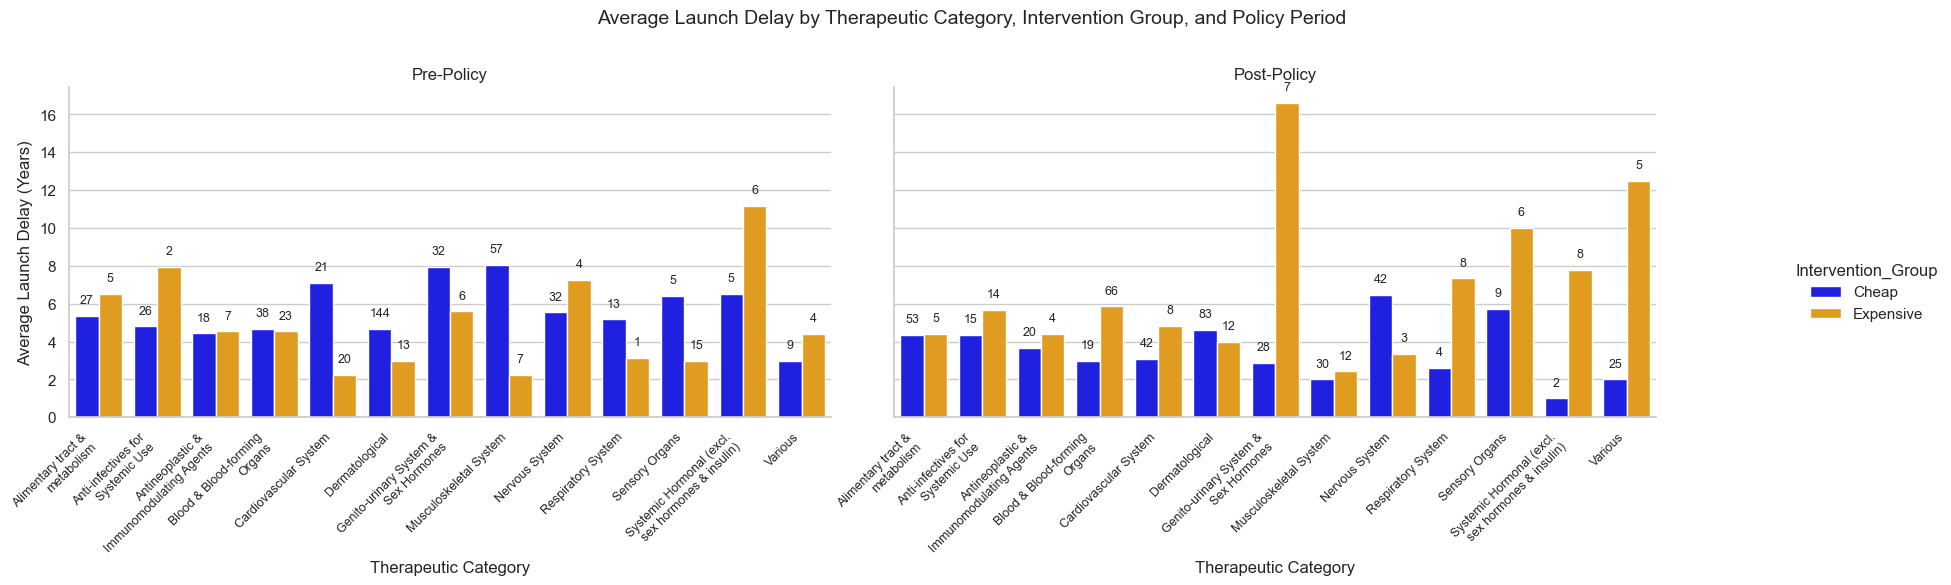

In [ ]:
# Clean & prepare data
Main_filtered = Main_non_missing_invention_year.dropna(
    subset=[
        "lagging_time",
        "Registration_Year",
        "Intervention_Group",
        "ATC_Main_Category",
    ]
).copy()

Main_filtered["Intervention_Group"] = Main_filtered["Intervention_Group"].map(
    {0: "Cheap", 1: "Expensive"}
)

# Add policy period column
Main_filtered["policy_period"] = Main_filtered["Registration_Year"].apply(
    lambda x: "Pre-Policy" if x < 2021 else "Post-Policy"
)


# Wrap long x-axis labels
def wrap_label(label, max_words=3):
    words = label.split()
    if len(words) > max_words:
        return "\n".join(textwrap.wrap(label, width=25))
    return label


Main_filtered["ATC_Main_Category"] = Main_filtered["ATC_Main_Category"].apply(
    wrap_label
)

# Compute group totals
group_totals = (
    Main_filtered.groupby(["policy_period", "Intervention_Group"])
    .size()
    .reset_index(name="total")
)

# Summary stats
summary = (
    Main_filtered.groupby(["policy_period", "ATC_Main_Category", "Intervention_Group"])
    .agg(lagging_time_mean=("lagging_time", "mean"), count=("lagging_time", "size"))
    .reset_index()
)

# Merge for percent calculation
summary = summary.merge(
    group_totals, on=["policy_period", "Intervention_Group"], how="left"
)
summary["percent"] = 100 * summary["count"] / summary["total"]
summary["label"] = summary["count"].astype(int).astype(str)  # 👈 Only show n

# Set custom colors
palette = {"Cheap": "blue", "Expensive": "orange"}

# Plot using FacetGrid
g = sns.catplot(
    data=summary,
    x="ATC_Main_Category",
    y="lagging_time_mean",
    hue="Intervention_Group",
    col="policy_period",
    col_order=["Pre-Policy", "Post-Policy"],
    kind="bar",
    height=6,
    aspect=1.5,
    palette=palette,
)

# Set axis labels and title
g.set_axis_labels("Therapeutic Category", "Average Launch Delay (Years)")
g.set_titles("{col_name}")
g.fig.suptitle(
    "Average Launch Delay by Therapeutic Category, Intervention Group, and Policy Period",
    fontsize=14,
)

# Style x-axis
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment("right")
        label.set_fontsize(9)

# Add count labels above bars
for ax, (_, subdata) in zip(g.axes.flat, summary.groupby("policy_period")):
    for bar, label in zip(ax.patches, subdata["label"]):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 0.5, label, ha="center", va="bottom", fontsize=9)

# Adjust layout
plt.tight_layout()
g.fig.subplots_adjust(top=0.85, bottom=0.3, right=0.85)

plt.show()


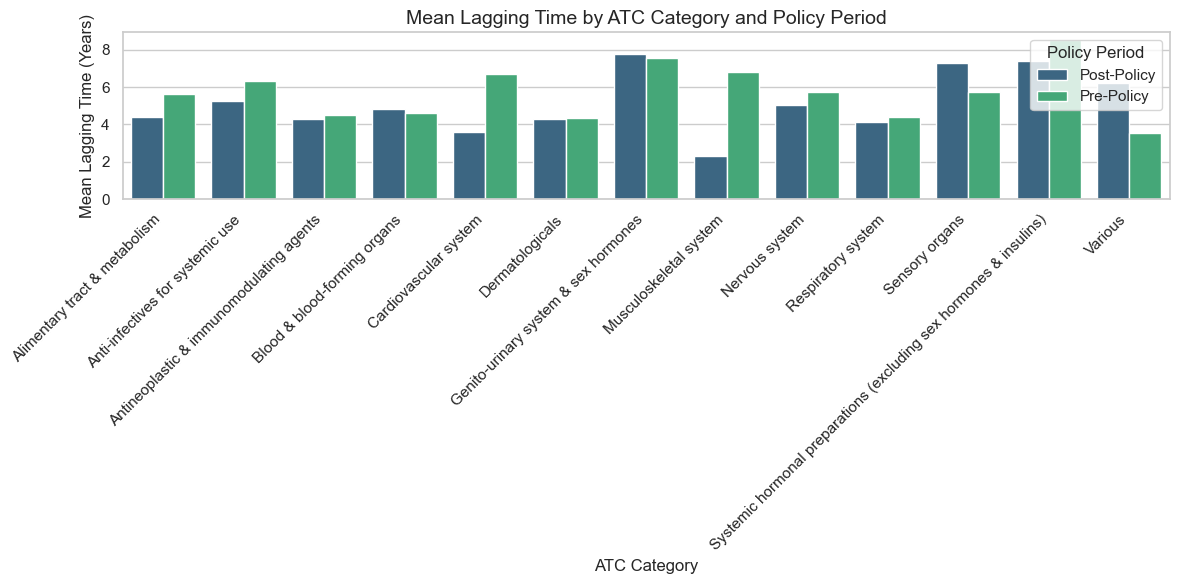

In [ ]:
# Filter the data to include only relevant columns and drop missing values
filtered_data = Main_non_missing_invention_year.dropna(
    subset=["lagging_time", "ATC_Main_Category", "policy_period"]
)

# Group by ATC category and policy period to calculate the mean lagging time
summary = (
    filtered_data.groupby(["ATC_Main_Category", "policy_period"])
    .agg(mean_lagging_time=("lagging_time", "mean"))
    .reset_index()
)

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary,
    x="ATC_Main_Category",
    y="mean_lagging_time",
    hue="policy_period",
    palette="viridis",
)

# Customize the plot
plt.title("Mean Lagging Time by ATC Category and Policy Period", fontsize=14)
plt.xlabel("ATC Category", fontsize=12)
plt.ylabel("Mean Lagging Time (Years)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Policy Period", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()

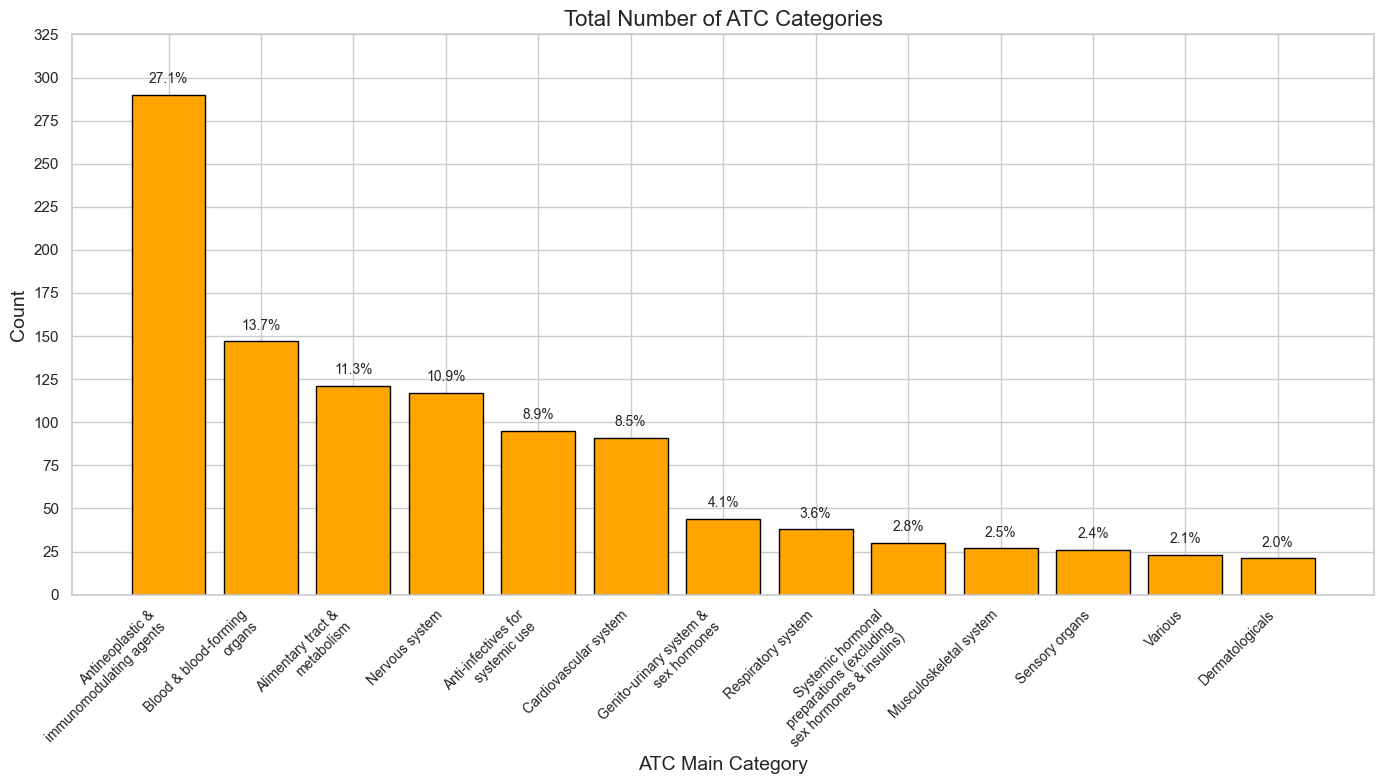

In [ ]:
# Count the number of occurrences for each ATC category
atc_counts = Main_non_missing_invention_year["ATC_Main_Category"].value_counts()

# Calculate percentages
total = atc_counts.sum()
percentages = 100 * atc_counts / total


# Wrap the x-axis labels
def wrap_labels(labels, width=25):
    return ["\n".join(textwrap.wrap(label, width)) for label in labels]


wrapped_labels = wrap_labels(atc_counts.index)

# Bar colors
bar_colors = "orange"  # change as you like

# Plotting
plt.figure(figsize=(14, 8))
bars = plt.bar(wrapped_labels, atc_counts.values, color=bar_colors, edgecolor="black")

plt.title("Total Number of ATC Categories", fontsize=16)
plt.xlabel("ATC Main Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(range(0, int(atc_counts.max()) + 50, 25))

# Add percentage labels on top of bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
        height + 5,  # y position: just above the bar
        f"{pct:.1f}%",  # text to display
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Drop rows where price is missing
df = Main_non_missing_invention_year.copy()
df = df[df["Price_Per_Unit_(LCU)"].notna()]

# Step 2: Calculate median
ppu_median = df["Price_Per_Unit_(LCU)"].median()

# Step 3: Create Intervention_Group
df["Intervention_Group"] = df["Price_Per_Unit_(LCU)"].apply(
    lambda x: "Expensive" if x > ppu_median else "Cheap"
)

# Optional: Confirm it looks right
print(df["Intervention_Group"].value_counts())

Intervention_Group
Cheap        535
Expensive    535
Name: count, dtype: int64


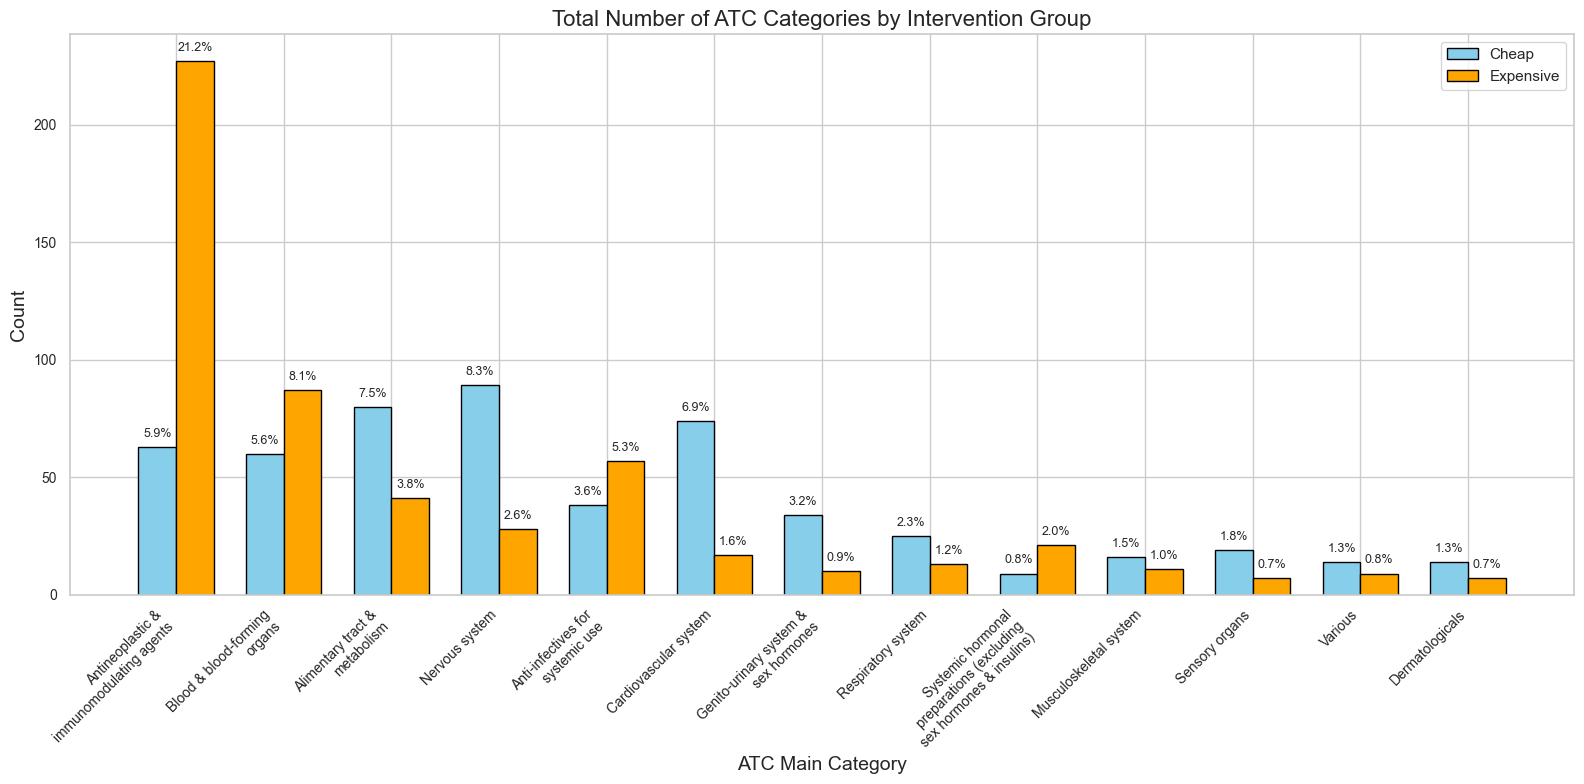

In [ ]:
# Group the data by ATC category and intervention group
grouped = (
    df.groupby(["ATC_Main_Category", "Intervention_Group"]).size().unstack(fill_value=0)
)

# Sort by total count
grouped = grouped.loc[grouped.sum(axis=1).sort_values(ascending=False).index]

# Calculate percentages within total count
totals = grouped.sum().sum()
percentages = 100 * grouped / totals


# Wrapping x-axis labels
def wrap_labels(labels, width=25):
    return ["\n".join(textwrap.wrap(label, width)) for label in labels]


wrapped_labels = wrap_labels(grouped.index)

# Plotting setup
x = np.arange(len(grouped))
width = 0.35  # Width of each bar

plt.figure(figsize=(16, 8))
bars1 = plt.bar(
    x - width / 2,
    grouped["Cheap"],
    width,
    label="Cheap",
    color="skyblue",
    edgecolor="black",
)
bars2 = plt.bar(
    x + width / 2,
    grouped["Expensive"],
    width,
    label="Expensive",
    color="orange",
    edgecolor="black",
)

plt.xlabel("ATC Main Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Total Number of ATC Categories by Intervention Group", fontsize=16)
plt.xticks(x, wrapped_labels, rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Add percentage labels
for bars, label in zip([bars1, bars2], ["Cheap", "Expensive"]):
    for bar in bars:
        height = bar.get_height()
        pct = (height / totals) * 100
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 3,
            f"{pct:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()